# Xgboost
---

In [26]:
# load the data
import seaborn as sns

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

diamonds = sns.load_dataset("diamonds")

diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [27]:
diamonds.shape # (53940, 10)

(53940, 10)

In [3]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [4]:
# shapiro wilk test for normality of price
from scipy.stats import shapiro

stat, p = shapiro(diamonds['price'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:  
        print('Sample looks Gaussian (fail to reject H0)')
else:
            print('Sample does not look Gaussian (reject H0)')


Statistics=0.798, p=0.000
Sample does not look Gaussian (reject H0)


<Axes: xlabel='price', ylabel='Density'>

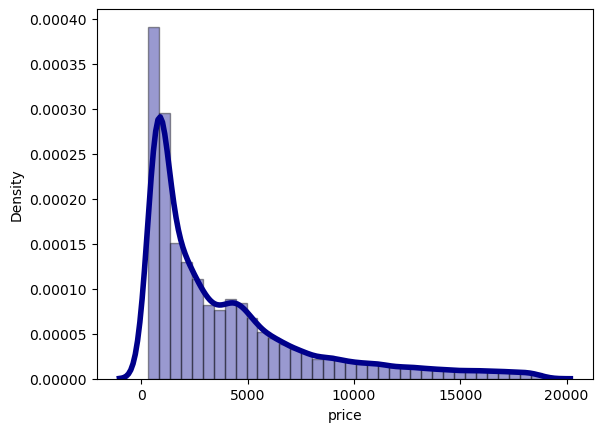

In [5]:
# plot the distribution of price
sns.distplot(diamonds['price'], hist=True, kde=True,
                bins=int(180/5), color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4})

How to Build an XGBoost DMatrix
---

In this tutorial, we will first try to predict diamond prices using their physical measurements, so our target will be the price column.

In [28]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

The dataset has three categorical columns. Normally, you would encode them with ordinal or one-hot encoding, but XGBoost has the ability to internally deal with categoricals.

The way to enable this feature is to cast the `categorical columns into Pandas category data type` (by default, they are treated as text columns):

In [29]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

Now, when you print the dtypes attribute, you'll see that we have three category features

In [9]:
print (X.dtypes)

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
x           float64
y           float64
z           float64
dtype: object


In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
# create regression matrices
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

#The class accepts both the training features and the labels. \
# To enable automatic encoding of Pandas category columns, we also set enable_categorical to True.


After building the DMatrices, you `should choose a value for the objective parameter.`
It tells XGBoost the machine learning problem you are trying to solve and what metrics or loss functions to use to solve that problem.

### Training 

In [33]:
#define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

#Inside this initial params, we are also setting tree_method to gpu_hist, which enables GPU acceleration.

`Now, we set another parameter called num_boost_round, which stands for number of boosting rounds. Internally, XGBoost minimizes the loss function RMSE in small incremental rounds (more on this later). This parameter specifies the amount of those rounds.`

`The ideal number of rounds is found through hyperparameter tuning. For now, we will just set it to 100:`

In [41]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(params, dtrain_reg, n)

# Predict the labels of the test set
preds = model.predict(dtest_reg)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 540.832117


`We’ve got a base score ~540$, which was the performance of a base model with default parameters. There are two ways we can improve it— by performing cross-validation and hyperparameter tuning. But before that, let’s see a quicker way of evaluating XGBoost models.`

### Using Validation Sets During Training

In [42]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 100

In [44]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

In [45]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
)

[0]	train-rmse:3985.31595	validation-rmse:3930.87087
[1]	train-rmse:2849.92126	validation-rmse:2812.52945
[2]	train-rmse:2061.76472	validation-rmse:2034.91266
[3]	train-rmse:1521.58802	validation-rmse:1509.03801
[4]	train-rmse:1158.20689	validation-rmse:1155.77477
[5]	train-rmse:918.95666	validation-rmse:922.81058
[6]	train-rmse:765.71970	validation-rmse:778.96367
[7]	train-rmse:671.73734	validation-rmse:692.56259
[8]	train-rmse:612.92636	validation-rmse:638.83852
[9]	train-rmse:578.33182	validation-rmse:608.53984
[10]	train-rmse:557.19710	validation-rmse:591.03042
[11]	train-rmse:542.58916	validation-rmse:578.99646
[12]	train-rmse:534.88302	validation-rmse:573.25964
[13]	train-rmse:527.20423	validation-rmse:566.28647
[14]	train-rmse:520.90582	validation-rmse:561.97563
[15]	train-rmse:515.69808	validation-rmse:558.92935
[16]	train-rmse:512.45290	validation-rmse:557.84167
[17]	train-rmse:507.50759	validation-rmse:556.68519
[18]	train-rmse:504.04144	validation-rmse:553.56230
[19]	train-r

In [46]:
#Model scores from 39000's to just 5400's. This is a huge improvement!

In real-world projects, you usually train for thousands of boosting rounds, which means that many rows of output. To reduce them, you can use the verbose_eval parameter, which forces XGBoost to print performance updates every vebose_eval rounds:

In [48]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 100

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10 # Every ten rounds
)

[0]	validation-rmse:3930.87087	train-rmse:3985.31595
[10]	validation-rmse:591.03042	train-rmse:557.19710
[20]	validation-rmse:550.76666	train-rmse:495.31647
[30]	validation-rmse:547.16647	train-rmse:467.13670
[40]	validation-rmse:544.10422	train-rmse:447.26879
[50]	validation-rmse:543.97371	train-rmse:432.51681
[60]	validation-rmse:544.77874	train-rmse:420.72943
[70]	validation-rmse:544.77491	train-rmse:408.72053
[80]	validation-rmse:544.33808	train-rmse:395.88816
[90]	validation-rmse:545.99682	train-rmse:383.62262
[99]	validation-rmse:545.38842	train-rmse:378.37454


Generally, the more rounds there are, the more XGBoost tries to minimize the loss. But this doesn’t mean the loss will always go down. Let’s try with 5000 boosting rounds with the verbosity of 500:

In [49]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 5000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=250
)


[0]	validation-rmse:3930.87087	train-rmse:3985.31595
[250]	validation-rmse:557.68923	train-rmse:282.14076
[500]	validation-rmse:567.09440	train-rmse:202.29270
[750]	validation-rmse:571.09355	train-rmse:153.40105
[1000]	validation-rmse:573.92496	train-rmse:124.11251
[1250]	validation-rmse:575.80595	train-rmse:102.84756
[1500]	validation-rmse:577.05346	train-rmse:86.53817
[1750]	validation-rmse:578.72790	train-rmse:74.95409
[2000]	validation-rmse:579.29924	train-rmse:64.88654
[2250]	validation-rmse:580.10885	train-rmse:56.54860
[2500]	validation-rmse:580.64166	train-rmse:49.60797
[2750]	validation-rmse:581.06804	train-rmse:43.65126
[3000]	validation-rmse:581.33497	train-rmse:39.07501
[3250]	validation-rmse:581.68045	train-rmse:35.19566
[3500]	validation-rmse:581.94197	train-rmse:31.53707
[3750]	validation-rmse:582.01889	train-rmse:28.69983
[4000]	validation-rmse:582.09487	train-rmse:26.22932
[4250]	validation-rmse:582.27258	train-rmse:24.02182
[4500]	validation-rmse:582.35214	train-rmse:

We get the lowest loss before round 500. After that, even though training loss keeps going down, the validation loss (the one we care about) keeps increasing.

When given an unnecessary number of boosting rounds, XGBoost starts to overfit and memorize the dataset. This, in turn, leads to validation performance drop because the model is memorizing instead of generalizing.

Remember, we want the `golden middle:` a model that learned just enough patterns in training that it gives the highest performance on the validation set. So, how do we find the perfect number of boosting rounds, then?

We will use a technique called `early stopping.` Early stopping forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

This means we can set as high a number of boosting rounds as long as we set a sensible number of early stopping rounds.

For example, let’s use 10000 boosting rounds and set the early_stopping_rounds parameter to 50. This way, XGBoost will automatically stop the training if validation loss doesn't improve for 50 consecutive rounds.

In [50]:
n = 10000


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=50
)

[0]	validation-rmse:3930.87087	train-rmse:3985.31595
[50]	validation-rmse:543.97371	train-rmse:432.51681
[100]	validation-rmse:545.56388	train-rmse:377.95218
[150]	validation-rmse:550.39816	train-rmse:337.94196
[200]	validation-rmse:554.85898	train-rmse:309.24955
[250]	validation-rmse:557.68923	train-rmse:282.14076
[300]	validation-rmse:562.06936	train-rmse:260.56315
[350]	validation-rmse:563.10432	train-rmse:241.85718
[400]	validation-rmse:564.23042	train-rmse:228.55880
[450]	validation-rmse:565.91072	train-rmse:214.04749
[500]	validation-rmse:567.09440	train-rmse:202.29270
[550]	validation-rmse:567.97453	train-rmse:190.05638
[600]	validation-rmse:568.63118	train-rmse:179.81322
[650]	validation-rmse:569.04335	train-rmse:170.49103
[700]	validation-rmse:569.82263	train-rmse:162.18310
[750]	validation-rmse:571.09355	train-rmse:153.40105
[800]	validation-rmse:571.55832	train-rmse:146.51777
[850]	validation-rmse:572.45668	train-rmse:140.40240
[900]	validation-rmse:573.03163	train-rmse:134.